In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('C:/Users/fatem/Downloads/stocks.csv')

In [4]:
df.head()

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000


In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
print(df.isnull().sum())

Ticker       0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [7]:
print(df.groupby('Ticker')['Close'].describe())

        count        mean        std         min         25%         50%  \
Ticker                                                                     
AAPL     62.0  158.240645   7.360485  145.309998  152.077499  158.055000   
GOOG     62.0  100.631532   6.279464   89.349998   94.702501  102.759998   
MSFT     62.0  275.039839  17.676231  246.270004  258.742500  275.810013   
NFLX     62.0  327.614677  18.554419  292.760010  315.672493  325.600006   

               75%         max  
Ticker                          
AAPL    165.162506  173.570007  
GOOG    105.962503  109.459999  
MSFT    287.217506  310.649994  
NFLX    338.899994  366.829987  


## Exploratory Data Analysis (EDA)

### Price Trends over time

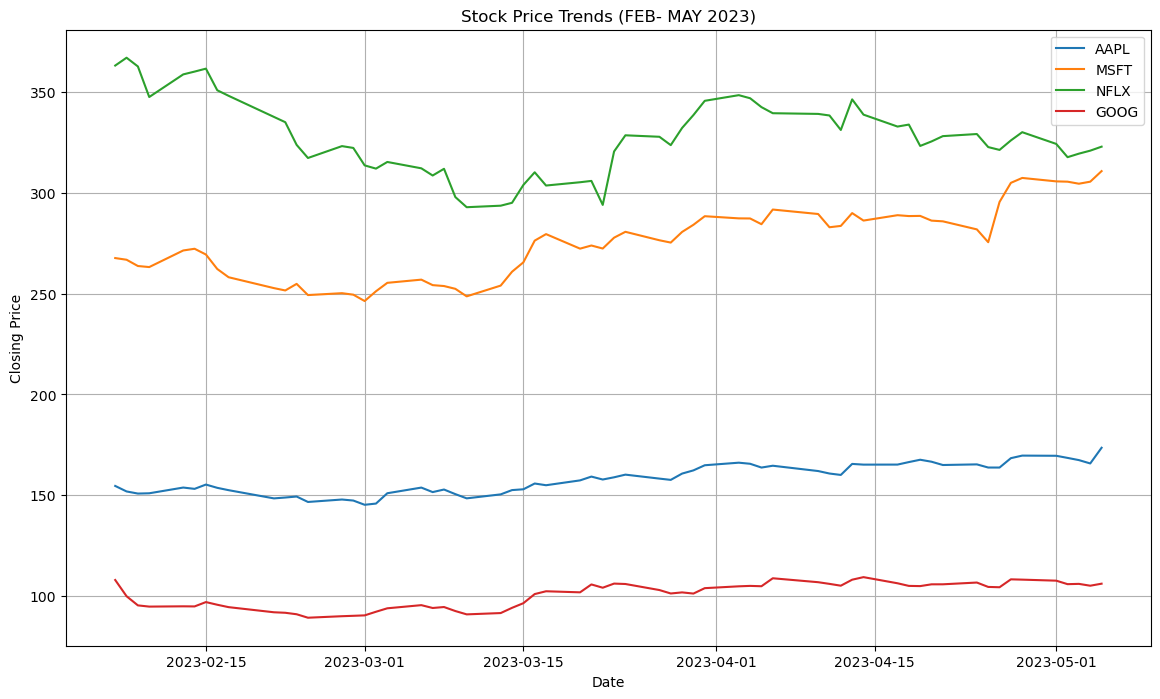

In [12]:
plt.figure(figsize=(14,8))
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker']==ticker]
    plt.plot(ticker_data['Date'],ticker_data['Close'],label=ticker)

plt.title('Stock Price Trends (FEB- MAY 2023)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()

### Calculate daily returns

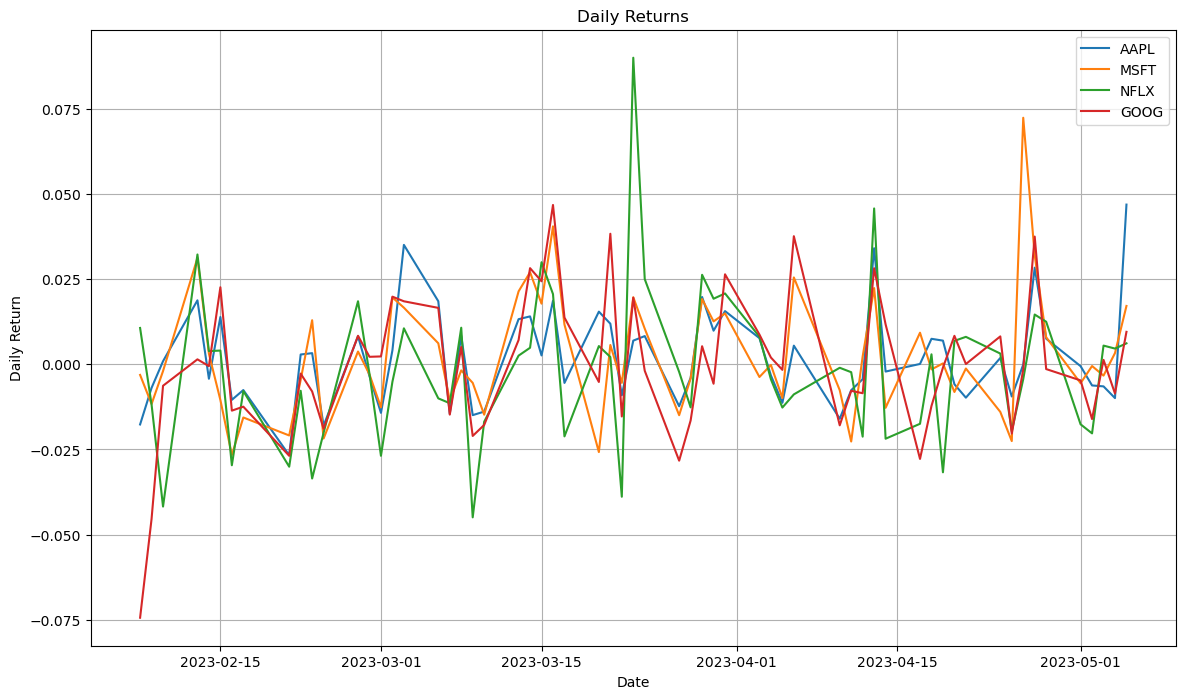

In [13]:

df['Daily_Return'] = df.groupby('Ticker')['Close'].pct_change()

plt.figure(figsize=(14, 8))
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker]
    plt.plot(ticker_data['Date'], ticker_data['Daily_Return'], label=ticker)
    
plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid()
plt.show()

### Volatitlity analysis

In [17]:
volatility = df.groupby('Ticker')['Daily_Return'].std() * np.sqrt(252)  # Annualized volatility
print("\nAnnualized Volatility:")
print(volatility.sort_values(ascending=False))


Annualized Volatility:
Ticker
NFLX    0.356880
GOOG    0.328764
MSFT    0.283849
AAPL    0.224660
Name: Daily_Return, dtype: float64


### Feature Engineering

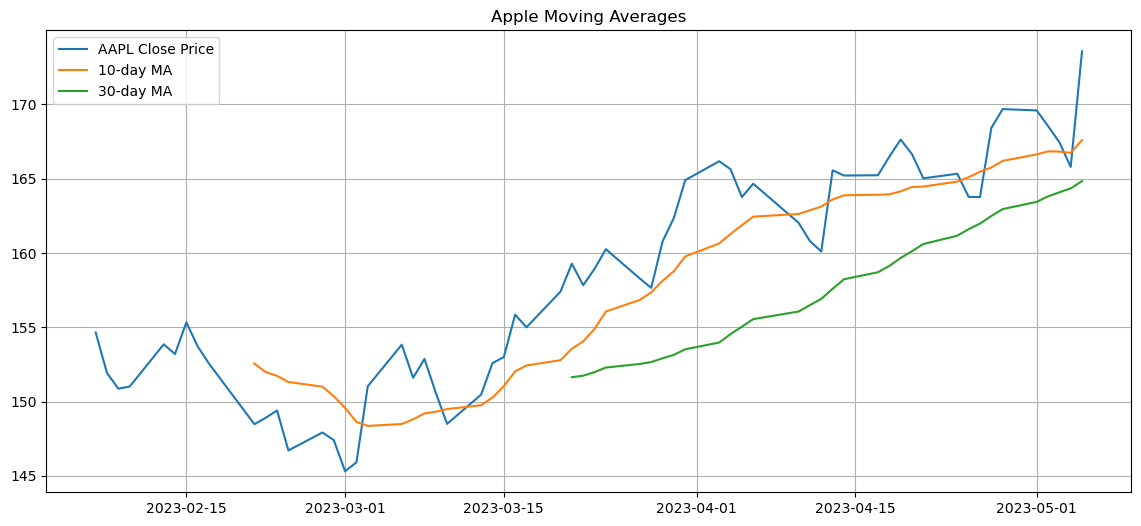

In [18]:
# Calculate 10-day and 30-day moving averages
df['MA_10'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=10).mean())
df['MA_30'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=30).mean())

# Plot moving averages for AAPL
aapl = df[df['Ticker'] == 'AAPL']
plt.figure(figsize=(14, 6))
plt.plot(aapl['Date'], aapl['Close'], label='AAPL Close Price')
plt.plot(aapl['Date'], aapl['MA_10'], label='10-day MA')
plt.plot(aapl['Date'], aapl['MA_30'], label='30-day MA')
plt.title('Apple Moving Averages')
plt.legend()
plt.grid()
plt.show()

In [19]:
# Calculate RSI (14-day)
def compute_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

for ticker in df['Ticker'].unique():
    mask = df['Ticker'] == ticker
    df.loc[mask, 'RSI'] = compute_rsi(df[mask])

### Correlation Analysis

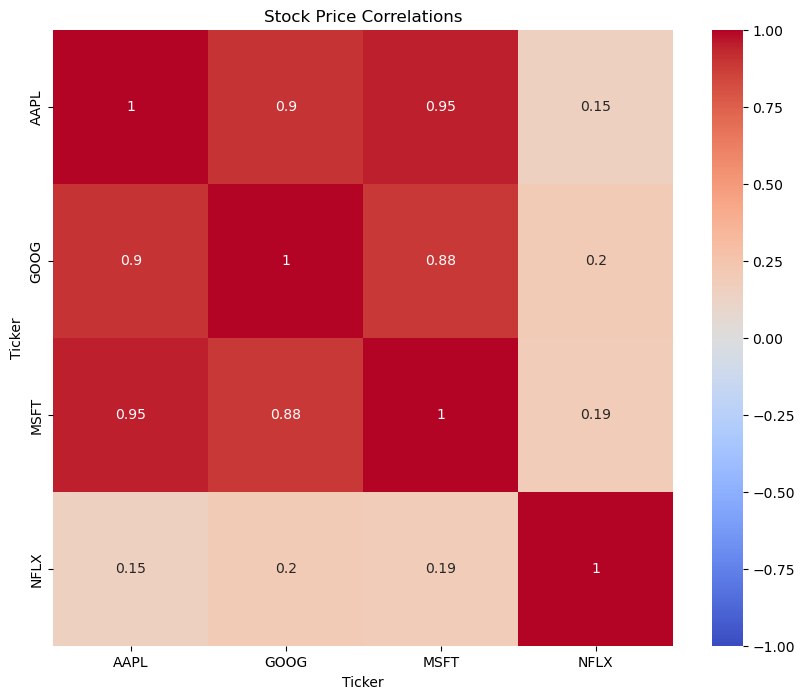

In [20]:
# Pivot to get closing prices by date
pivot_df = df.pivot(index='Date', columns='Ticker', values='Close')

# Calculate correlation matrix
corr_matrix = pivot_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Stock Price Correlations')
plt.show()

# Performance Comparison

### Cumulative Returns

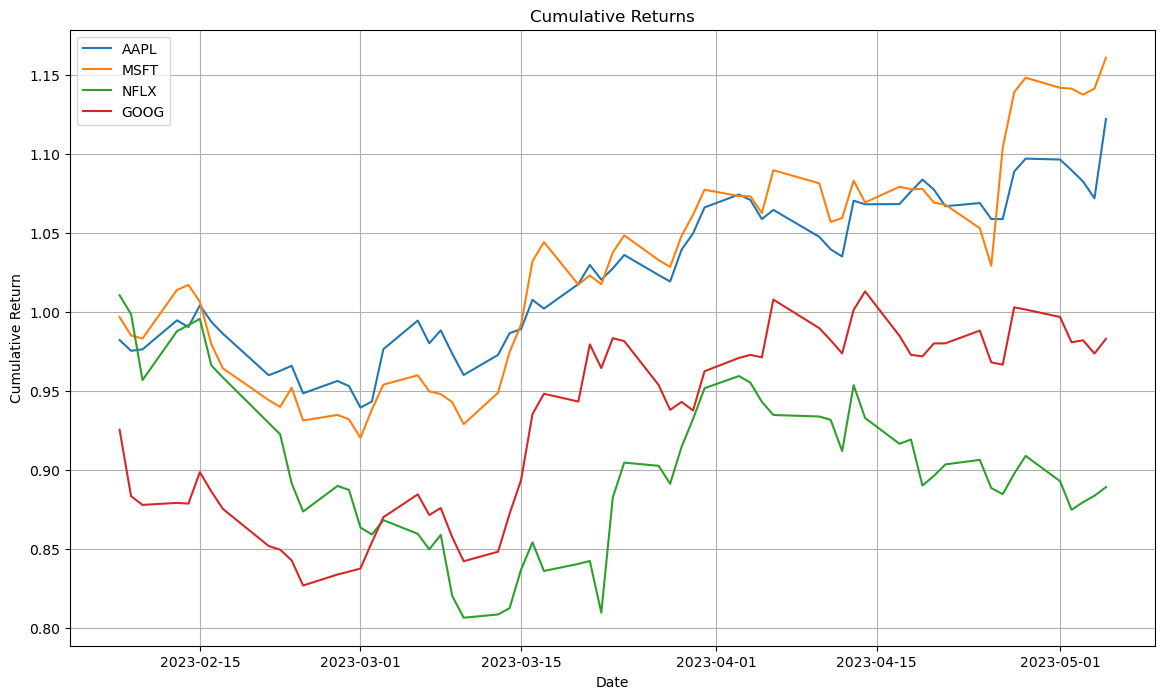

In [21]:
# Calculate cumulative returns
for ticker in df['Ticker'].unique():
    mask = df['Ticker'] == ticker
    df.loc[mask, 'Cumulative_Return'] = (1 + df.loc[mask, 'Daily_Return']).cumprod()

plt.figure(figsize=(14, 8))
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker]
    plt.plot(ticker_data['Date'], ticker_data['Cumulative_Return'], label=ticker)
    
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

### Risk-Return Profile

In [22]:
# Calculate average daily return and volatility
performance = df.groupby('Ticker').agg({
    'Daily_Return': ['mean', 'std'],
    'Close': ['first', 'last']
})

performance.columns = ['Avg_Daily_Return', 'Daily_Volatility', 'Initial_Price', 'Final_Price']
performance['Total_Return'] = (performance['Final_Price'] - performance['Initial_Price']) / performance['Initial_Price']
performance['Annualized_Volatility'] = performance['Daily_Volatility'] * np.sqrt(252)

print("\nPerformance Metrics:")
print(performance.sort_values('Total_Return', ascending=False))


Performance Metrics:
        Avg_Daily_Return  Daily_Volatility  Initial_Price  Final_Price  \
Ticker                                                                   
MSFT            0.002606          0.017881     267.559998   310.649994   
AAPL            0.001991          0.014152     154.649994   173.570007   
GOOG           -0.000067          0.020710     108.040001   106.214996   
NFLX           -0.001676          0.022481     362.950012   322.760010   

        Total_Return  Annualized_Volatility  
Ticker                                       
MSFT        0.161048               0.283849  
AAPL        0.122341               0.224660  
GOOG       -0.016892               0.328764  
NFLX       -0.110732               0.356880  
